#### Project Storm prediction in North of Madagascar
The porpuse of this project is a machine learning focused on forcasting thunderstorms in northern Madagascar, particularly around Nosy Be. The project aims to provide accurate short-term predictions (0–6 hours) to mitigate risks, protect lives, and support emergency responses in this vulnerable region.

#### Data importation

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
train_df = pd.read_csv('./Data/train.csv')
test_df = pd.read_csv('./Data/test.csv')

#### Data exploration

In [3]:
train_df.head(3)

,year,month,day,hour,minute,lat,lon,intensity,size,distance,Storm_NosyBe_1h,Storm_NosyBe_3h
0,2004,1,19,10,30,-13.6126,48.2281,468,1422,10.44,0,1
1,2004,1,19,10,45,-13.7039,48.2598,488,1881,13.34,0,1
2,2004,1,19,11,0,-13.7953,48.2918,424,1746,16.28,0,1


In [4]:
train_df.describe()

,year,month,day,hour,minute,lat,lon,intensity,size,distance,Storm_NosyBe_1h,Storm_NosyBe_3h
count,51077.000000,51077.000000,51077.000000,51077.000000,51077.000000,51077.000000,51077.000000,51077.000000,51077.000000,51077.000000,51077.000000,51077.000000
mean,2011.761908,4.760146,15.965444,13.619144,22.507489,-13.630660,48.779610,210.809934,3936.537483,24.690407,0.063571,0.056327
std,4.645697,4.311285,8.710566,5.576324,16.762922,0.618119,0.750511,86.580096,5694.273869,13.422355,0.243989,0.230554
min,2004.000000,1.000000,1.000000,0.000000,0.000000,-14.999500,47.500300,87.000000,45.000000,0.000000,0.000000,0.000000
25%,2008.000000,2.000000,8.000000,11.000000,15.000000,-14.081000,48.178300,144.000000,621.000000,14.320000,0.000000,0.000000
50%,2012.000000,3.000000,16.000000,14.000000,30.000000,-13.540100,48.757700,190.000000,1773.000000,21.930000,0.000000,0.000000
75%,2016.000000,11.000000,24.000000,17.000000,30.000000,-13.169700,49.307700,258.000000,4770.000000,33.840000,0.000000,0.000000
max,2019.000000,12.000000,31.000000,23.000000,45.000000,-12.500400,50.496900,928.000000,85266.000000,61.740000,1.000000,1.000000


#### Data Preparation and Features importance


In [5]:
def create_time_features(df):
    # Convert time columns to datetime
    df['datetime'] = pd.to_datetime(df[['year', 'month', 'day', 'hour', 'minute']])
    # Extract time features
    df['day_of_week'] = df['datetime'].dt.dayofweek
    df['hour_sin'] = np.sin(2 * np.pi * df['hour']/24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour']/24)
    df['minute_sin'] = np.sin(2 * np.pi * df['minute']/24)
    df['minute_cos'] = np.cos(2 * np.pi * df['minute']/24)
    return df



In [6]:
def create_spatial_features(df):
    # Avoid division by zero and handle size=0
    df['intensity_density'] = df['intensity'] / (df['size'].replace(1, np.nan))
    df['intensity_density'] = df['intensity_density'].fillna(0)
    df['storm_proximity'] = 1 / (df['distance'] + 1)
    return df

In [7]:
def create_storm_features(df):
    # Nosy Be Specific Cyclone Season (November to April)
    df['is_peak_cyclone_season'] = df['month'].apply(lambda x: 1 if x in [1, 2, 3] else 0)
    df['is_cyclone_season'] = df['month'].apply(lambda x: 1 if x in [11, 12, 1, 2, 3, 4] else 0)

    # Assign weights to months based on historical cyclone data
    cyclone_weights = {1: 0.9, 2: 0.8, 3: 0.7, 4: 0.4, 11: 0.6, 12: 0.7}
    df['cyclone_season_weight'] = df['month'].map(cyclone_weights).fillna(0)

    # Define day as 6 AM to 6 PM
    df['is_daytime'] = df['hour'].apply(lambda x: 1 if 6 <= x < 18 else 0)

    df['cyclone_daytime_interaction'] = df['is_cyclone_season'] * df['is_daytime']
    df['peak_cyclone_daytime_interaction'] = df['is_peak_cyclone_season'] * df['is_daytime']
    
    return df

In [8]:
def add_lag_features(df, lag_features, intervals):
    df = df.sort_values('datetime').reset_index(drop=True)
    for feat in lag_features:
        for lag_min, lag_steps in intervals.items():
            lag_col = f"{feat}_{lag_min}"
            df[lag_col] = df[feat].shift(lag_steps)
            df[lag_col] = df[lag_col].fillna(0)
    return df

def add_size_features(df):
    df['size_change_30'] = df['size'] - df['size_30']

    return df

In [9]:
def latlon_to_xy(df, lat_ref = -13.3 , lon_ref = 48.3 ):
    R = 6371.0  # Earth radius in kilometers
    rad = np.pi/180.0
    
    delta_lat = (df['lat'] - lat_ref) * rad
    delta_lon = (df['lon'] - lon_ref) * rad
    
    df['distance_y'] = delta_lat * R
    df['distance_x'] = delta_lon * R * np.cos(lat_ref * rad)

    df['radial_distance'] = np.sqrt(df['distance_x']**2 + df['distance_y']**2)
    df['bearing'] = np.arctan2(df['distance_y'], df['distance_x'])
    df['intensity_distance_interaction'] = df['radial_distance'] * df['intensity']
    return df

#### Apply feature engineering

In [10]:
# Apply feature engineering
train_df = create_time_features(train_df)
test_df = create_time_features(test_df)

train_df = create_spatial_features(train_df)
test_df = create_spatial_features(test_df)

train_df = create_storm_features(train_df)
test_df = create_storm_features(test_df)

train_df = latlon_to_xy(train_df)
test_df = latlon_to_xy(test_df)

# Define lag features and intervals
lag_features = ['intensity', 'size', 'distance', 'intensity_density', 'minute_sin', 'minute_cos', 'bearing']
lag_intervals = {30: 2, 60: 4}  # 30min -> 2 steps, 60min -> 4 steps

train_df = add_lag_features(train_df, lag_features, lag_intervals)
test_df = add_lag_features(test_df, lag_features, lag_intervals)

train_df = add_size_features(train_df)
test_df = add_size_features(test_df)



In [11]:
train_df.head(3)

,year,month,day,hour,minute,lat,lon,intensity,size,distance,...,distance_60,intensity_density_30,intensity_density_60,minute_sin_30,minute_sin_60,minute_cos_30,minute_cos_60,bearing_30,bearing_60,size_change_30
0,2004,1,19,10,30,-13.6126,48.2281,468,1422,10.44,...,0.0,0.000000,0.0,0.0,0.0,0.000000e+00,0.0,0.000000,0.0,1422.0
1,2004,1,19,10,45,-13.7039,48.2598,488,1881,13.34,...,0.0,0.000000,0.0,0.0,0.0,0.000000e+00,0.0,0.000000,0.0,1881.0
2,2004,1,19,11,0,-13.7953,48.2918,424,1746,16.28,...,0.0,0.329114,0.0,1.0,0.0,1.194340e-15,0.0,-1.791004,0.0,324.0


In [12]:
train_df.columns

Index(['year', 'month', 'day', 'hour', 'minute', 'lat', 'lon', 'intensity',
       'size', 'distance', 'Storm_NosyBe_1h', 'Storm_NosyBe_3h', 'datetime',
       'day_of_week', 'hour_sin', 'hour_cos', 'minute_sin', 'minute_cos',
       'intensity_density', 'storm_proximity', 'is_peak_cyclone_season',
       'is_cyclone_season', 'cyclone_season_weight', 'is_daytime',
       'cyclone_daytime_interaction', 'peak_cyclone_daytime_interaction',
       'distance_y', 'distance_x', 'radial_distance', 'bearing',
       'intensity_distance_interaction', 'intensity_30', 'intensity_60',
       'size_30', 'size_60', 'distance_30', 'distance_60',
       'intensity_density_30', 'intensity_density_60', 'minute_sin_30',
       'minute_sin_60', 'minute_cos_30', 'minute_cos_60', 'bearing_30',
       'bearing_60', 'size_change_30'],
      dtype='object')

In [13]:
train_df.describe()


,year,month,day,hour,minute,lat,lon,intensity,size,distance,...,distance_60,intensity_density_30,intensity_density_60,minute_sin_30,minute_sin_60,minute_cos_30,minute_cos_60,bearing_30,bearing_60,size_change_30
count,51077.000000,51077.000000,51077.000000,51077.000000,51077.000000,51077.000000,51077.000000,51077.000000,51077.000000,51077.000000,...,51077.000000,51077.000000,51077.000000,51077.000000,51077.000000,5.107700e+04,5.107700e+04,51077.000000,51077.000000,51077.000000
mean,2011.761908,4.760146,15.965444,13.619144,22.507489,-13.630660,48.779610,210.809934,3936.537483,24.690407,...,24.688341,0.236569,0.236560,-0.103730,-0.103717,2.490984e-01,2.490927e-01,-0.376019,-0.375923,0.066077
min,2004.000000,1.000000,1.000000,0.000000,0.000000,-14.999500,47.500300,87.000000,45.000000,0.000000,...,0.000000,0.000000,0.000000,-0.707107,-0.707107,-7.071068e-01,-7.071068e-01,-3.140414,-3.140414,-54639.000000
25%,2008.000000,2.000000,8.000000,11.000000,15.000000,-14.081000,48.178300,144.000000,621.000000,14.320000,...,14.320000,0.043594,0.043584,-0.707107,-0.707107,-7.071068e-01,-7.071068e-01,-1.337920,-1.337920,-774.000000
50%,2012.000000,3.000000,16.000000,14.000000,30.000000,-13.540100,48.757700,190.000000,1773.000000,21.930000,...,21.930000,0.114273,0.114268,-0.707107,-0.707107,1.194340e-15,1.194340e-15,-0.382499,-0.382499,99.000000
75%,2016.000000,11.000000,24.000000,17.000000,30.000000,-13.169700,49.307700,258.000000,4770.000000,33.840000,...,33.840000,0.309829,0.309829,1.000000,1.000000,7.071068e-01,7.071068e-01,0.242846,0.242846,1062.000000
max,2019.000000,12.000000,31.000000,23.000000,45.000000,-12.500400,50.496900,928.000000,85266.000000,61.740000,...,61.740000,2.777778,2.777778,1.000000,1.000000,1.000000e+00,1.000000e+00,3.139275,3.139275,59661.000000
std,4.645697,4.311285,8.710566,5.576324,16.762922,0.618119,0.750511,86.580096,5694.273869,13.422355,...,13.424113,0.293941,0.293945,0.699667,0.699662,6.615402e-01,6.615202e-01,1.337600,1.337539,5099.991852


#### Prepare Training data

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
# Prepare Training data
feature_cols = [
    'hour_sin', 'hour_cos', 
    'distance_x', 'distance_y', 'intensity', 'size', 'distance',
    'is_peak_cyclone_season', 
    'cyclone_season_weight', 'peak_cyclone_daytime_interaction', 'size_change_30', 'bearing'
]

# Add lag columns to feature_cols
for feat in lag_features:
    for lag_min in lag_intervals.keys():
        feature_cols.append(f"{feat}_{lag_min}")

X = train_df[feature_cols]
y_1h = train_df['Storm_NosyBe_1h']
y_3h = train_df['Storm_NosyBe_3h']


#### Split training and validation sets

In [16]:
x_full_train, x_test,y1h_full_train, y1h_test= train_test_split(X, y_1h, test_size=0.2, random_state=11)
x_train, x_val, y1h_train, y1h_val= train_test_split(x_full_train,y1h_full_train, test_size=0.25, random_state=11)

In [17]:
_, _, y3h_full_train, y3h_test = train_test_split(X, y_3h, test_size=0.2, random_state=11)
_, _, y3h_train, y3h_val= train_test_split(x_full_train,y3h_full_train, test_size=0.25, random_state=11)

In [18]:
x_train.head()

,hour_sin,hour_cos,distance_x,distance_y,intensity,size,distance,is_peak_cyclone_season,cyclone_season_weight,peak_cyclone_daytime_interaction,...,distance_30,distance_60,intensity_density_30,intensity_density_60,minute_sin_30,minute_sin_60,minute_cos_30,minute_cos_60,bearing_30,bearing_60
9387,-0.965926,-0.258819,72.718836,-3.958539,140,1899,13.00,1,0.9,1,...,13.34,13.93,1.140741,0.054989,1.000000,0.000000,1.194340e-15,1.000000e+00,-0.183264,-0.260005
31472,-0.500000,-0.866025,44.031688,-70.008326,224,3033,20.40,0,0.7,0,...,14.87,15.56,0.117778,0.017339,-0.707107,-0.707107,-7.071068e-01,7.071068e-01,-0.475215,-0.504648
17435,-0.707107,-0.707107,214.617957,-119.712458,100,234,44.60,0,0.6,0,...,39.05,46.23,0.142332,0.197691,-0.707107,-0.707107,-7.071068e-01,7.071068e-01,-0.541002,-0.548209
32938,-0.965926,-0.258819,-8.040193,52.039226,422,5670,16.12,1,0.8,1,...,12.37,7.21,0.102721,0.120799,0.000000,1.000000,1.000000e+00,1.194340e-15,1.521234,0.904204
5672,0.258819,-0.965926,16.415844,-72.421256,115,639,21.02,1,0.9,1,...,15.81,9.06,0.139535,0.021799,-0.707107,-0.707107,-7.071068e-01,7.071068e-01,2.320072,2.113702


#### trainning the Modele

In [19]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.tree import export_text

In [20]:

df_train = x_train.reset_index(drop=True)
df_val = x_val.reset_index(drop=True)
df_test = x_test.reset_index(drop=True)

In [21]:
df_full_train = x_full_train.reset_index(drop=True)

##### Decision Tree

In [22]:
train_dicts = df_train.fillna(0).to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

In [23]:
dt_model_1h = DecisionTreeClassifier()
dt_model_1h.fit(X_train, y1h_train)

DecisionTreeClassifier()

In [24]:
val_dicts = df_val.fillna(0).to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [25]:
y_pred = dt_model_1h.predict_proba(X_val)[:, 1]
roc_auc_score(y1h_val, y_pred)

0.686576592615371

In [26]:

y_pred = dt_model_1h.predict_proba(X_train)[:, 1]
roc_auc_score(y1h_train, y_pred)

1.0

In [27]:

dt_model_1h = DecisionTreeClassifier(max_depth=2)
dt_model_1h.fit(X_train, y1h_train)

DecisionTreeClassifier(max_depth=2)

In [28]:

y_pred = dt_model_1h.predict_proba(X_train)[:, 1]
auc = roc_auc_score(y1h_train, y_pred)
print('train:', auc)

y_pred = dt_model_1h.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y1h_val, y_pred)
print('val:', auc)

train: 0.7817901508315535
val: 0.7842266390449467


##### Decision tree Tunning
selecting max_depth
selecting min_samples_leaf

In [29]:
depths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, None]

for depth in depths: 
    dt_model_1h = DecisionTreeClassifier(max_depth=depth)
    dt_model_1h.fit(X_train, y1h_train)
    
    y_pred = dt_model_1h.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y1h_val, y_pred)
    
    print('%4s -> %.3f' % (depth, auc))

   1 -> 0.715
   2 -> 0.784
   3 -> 0.818
   4 -> 0.851
   5 -> 0.860
   6 -> 0.866
   7 -> 0.862
   8 -> 0.847
   9 -> 0.803
  10 -> 0.789
  15 -> 0.693
  20 -> 0.682
None -> 0.683


In [30]:

scores = []

for depth in [5, 6, 7]:
    for s in [1, 5, 10, 15, 20, 500, 100, 200]:
        dt_model_1h = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=s)
        dt_model_1h.fit(X_train, y1h_train)

        y_pred = dt_model_1h.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y1h_val, y_pred)
        
        scores.append((depth, s, auc))

In [31]:

columns = ['max_depth', 'min_samples_leaf', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

In [32]:

df_scores_pivot = df_scores.pivot(index='min_samples_leaf', columns=['max_depth'], values=['auc'])
df_scores_pivot.round(3)

auc              
max_depth             5      6      7
min_samples_leaf                     
1                 0.860  0.867  0.861
5                 0.860  0.873  0.867
10                0.861  0.872  0.868
15                0.861  0.868  0.857
20                0.861  0.868  0.858
100               0.862  0.872  0.872
200               0.864  0.872  0.871
500               0.867  0.871  0.873

<Axes: xlabel='None-max_depth', ylabel='min_samples_leaf'>

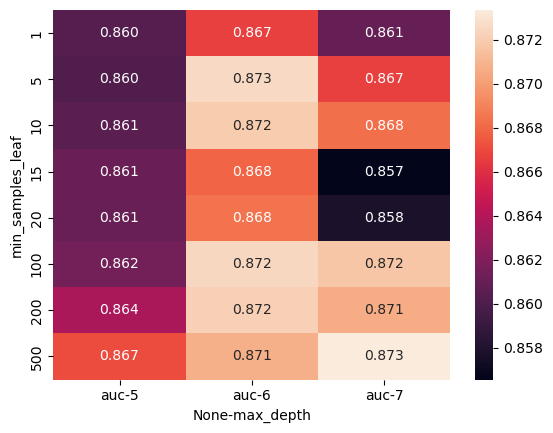

In [33]:

sns.heatmap(df_scores_pivot, annot=True, fmt=".3f")

So: let's fix max_depth: 6 and min_samples_leaf : 5 

In [34]:
dt_model_1h = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)
dt_model_1h.fit(X_train, y1h_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)

In [36]:
print(export_text(dt_model_1h, feature_names=list(dv.get_feature_names_out())))

|--- distance <= 12.06
|   |--- intensity <= 214.50
|   |   |--- distance <= 7.90
|   |   |   |--- intensity <= 179.50
|   |   |   |   |--- intensity_density_30 <= 0.02
|   |   |   |   |   |--- intensity_density_60 <= 0.01
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- intensity_density_60 >  0.01
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- intensity_density_30 >  0.02
|   |   |   |   |   |--- intensity_30 <= 295.00
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- intensity_30 >  295.00
|   |   |   |   |   |   |--- class: 0
|   |   |   |--- intensity >  179.50
|   |   |   |   |--- cyclone_season_weight <= 0.65
|   |   |   |   |   |--- distance <= 6.52
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- distance >  6.52
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- cyclone_season_weight >  0.65
|   |   |   |   |   |--- distance_x <= 8.24
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- distance_x >  8.24


##### Trainning random forest

In [37]:

from sklearn.ensemble import RandomForestClassifier

let's test Random forest 

In [38]:
scores = []

for n in range(10, 201, 10):
    rf_model_1h = RandomForestClassifier(n_estimators=n, random_state=1)
    rf_model_1h.fit(X_train, y1h_train)

    y_pred = rf_model_1h.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y1h_val, y_pred)
    
    scores.append((n, auc))

In [39]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'auc'])

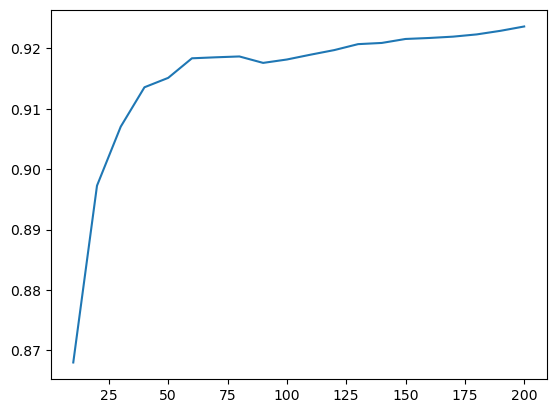

In [40]:

plt.plot(df_scores.n_estimators, df_scores.auc)

In [41]:
scores = []

for d in [5, 10, 15]:
    for n in range(10, 201, 10):
        rf_model_1h = RandomForestClassifier(n_estimators=n,
                                    max_depth=d,
                                    random_state=1)
        rf_model_1h.fit(X_train, y1h_train)

        y_pred = rf_model_1h.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y1h_val, y_pred)

        scores.append((d, n, auc))

In [42]:

columns = ['max_depth', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

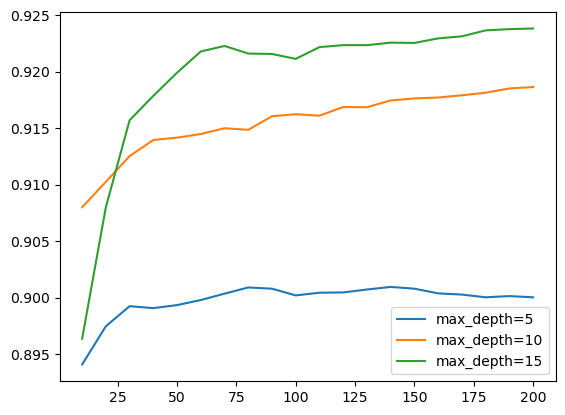

In [43]:

for d in [5, 10, 15]:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             label='max_depth=%d' % d)

plt.legend()

Let's us max depth 